In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.simplefilter('ignore')

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error
import datetime

In [3]:
dengue_test = pd.read_csv('./dengue_features_test.csv')

In [4]:
dengue_train_cases = pd.read_csv('./dengue_labels_train.csv')

In [5]:
dengue_train = pd.read_csv('./dengue_features_train.csv')

In [6]:
#merging train dataset with train dataset with total_cases
dengue_merged = pd.merge(dengue_train_cases, dengue_train, on=['city', 'year', 'weekofyear'])

In [7]:
#Average cases/week total dataset
baseline = dengue_merged['total_cases'].sum()/len(dengue_merged['total_cases'])
print(baseline)

24.67513736263736


In [8]:
#Will separate main dataset into 2. One per city.
san_juan = dengue_merged[dengue_merged['city'] == 'sj']
iquitos = dengue_merged[(dengue_merged['city']=='iq')&(dengue_merged['year']>2001)]

In [9]:
#19 years worth of data
san_juan.shape

(936, 25)

In [10]:
baseline_san_juan = san_juan['total_cases'].sum()/len(san_juan['total_cases'])
print(baseline_san_juan)

34.18055555555556


In [11]:
san_juan['total_cases'].var()

2640.045439691045

In [12]:
#9 years worth of data. Cut first 2 years of dataset as did not seem very complete.
iquitos.shape

(442, 25)

In [13]:
baseline_iquitos = iquitos['total_cases'].sum()/len(iquitos['total_cases'])
print(baseline_iquitos)

8.85972850678733


In [14]:
iquitos['total_cases'].var()

125.13674187623779

In [15]:
#best not to delete rows as will use Time Series
san_juan = san_juan.fillna(method = 'ffill')
iquitos = iquitos.fillna(method = 'ffill')

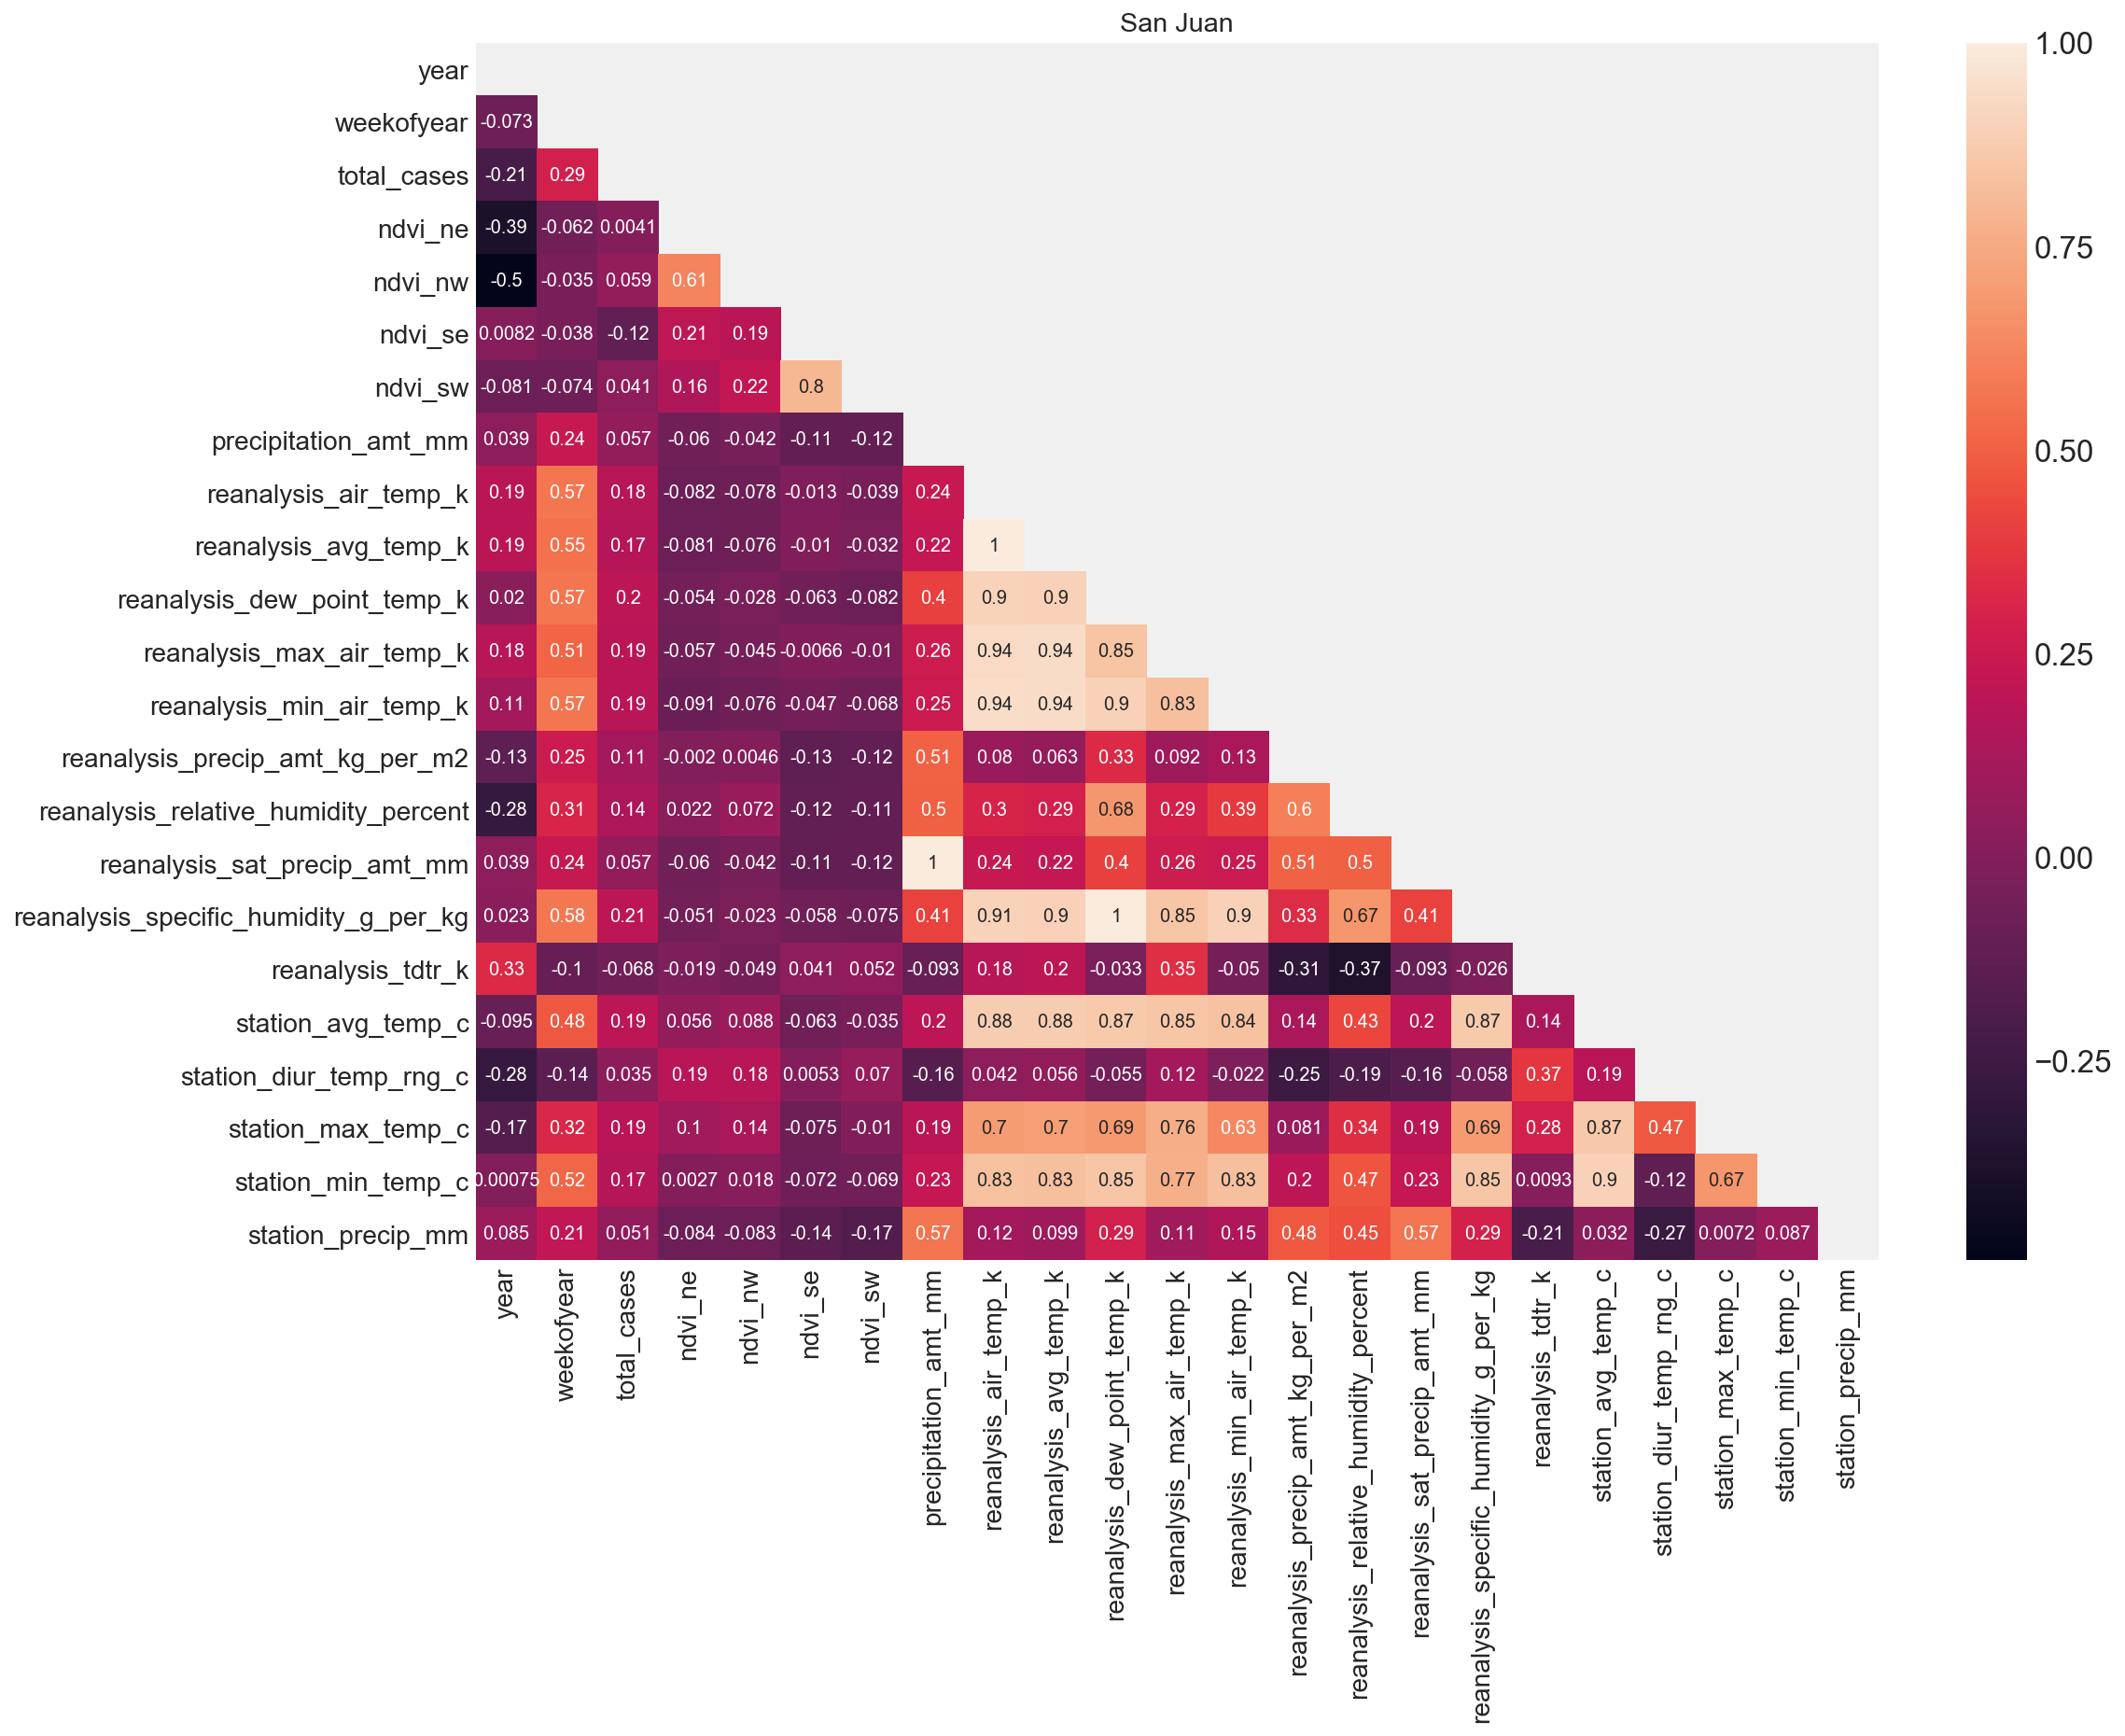

In [16]:
#Heatmap of only San Juan
sjcorr = san_juan.corr()

fig, ax = plt.subplots(figsize=(15,12))

mask = np.zeros_like(sjcorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(sjcorr, mask=mask, ax=ax, annot=True)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

ax.set_title('San Juan')
plt.show()

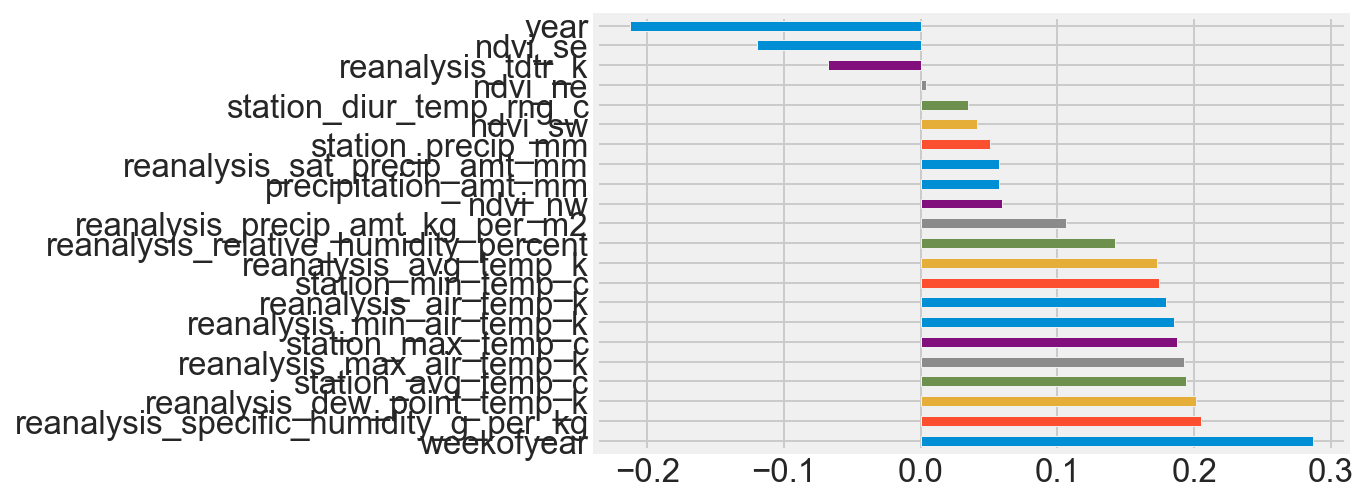

In [17]:
#Correlations are very week with the target of 'total cases', the max scale is 0.3. 
(sjcorr
     .total_cases
     .drop('total_cases') # don't compare with itself
     .sort_values(ascending=False)
     .plot
     .barh())

#Scale is tiny...not useful features!

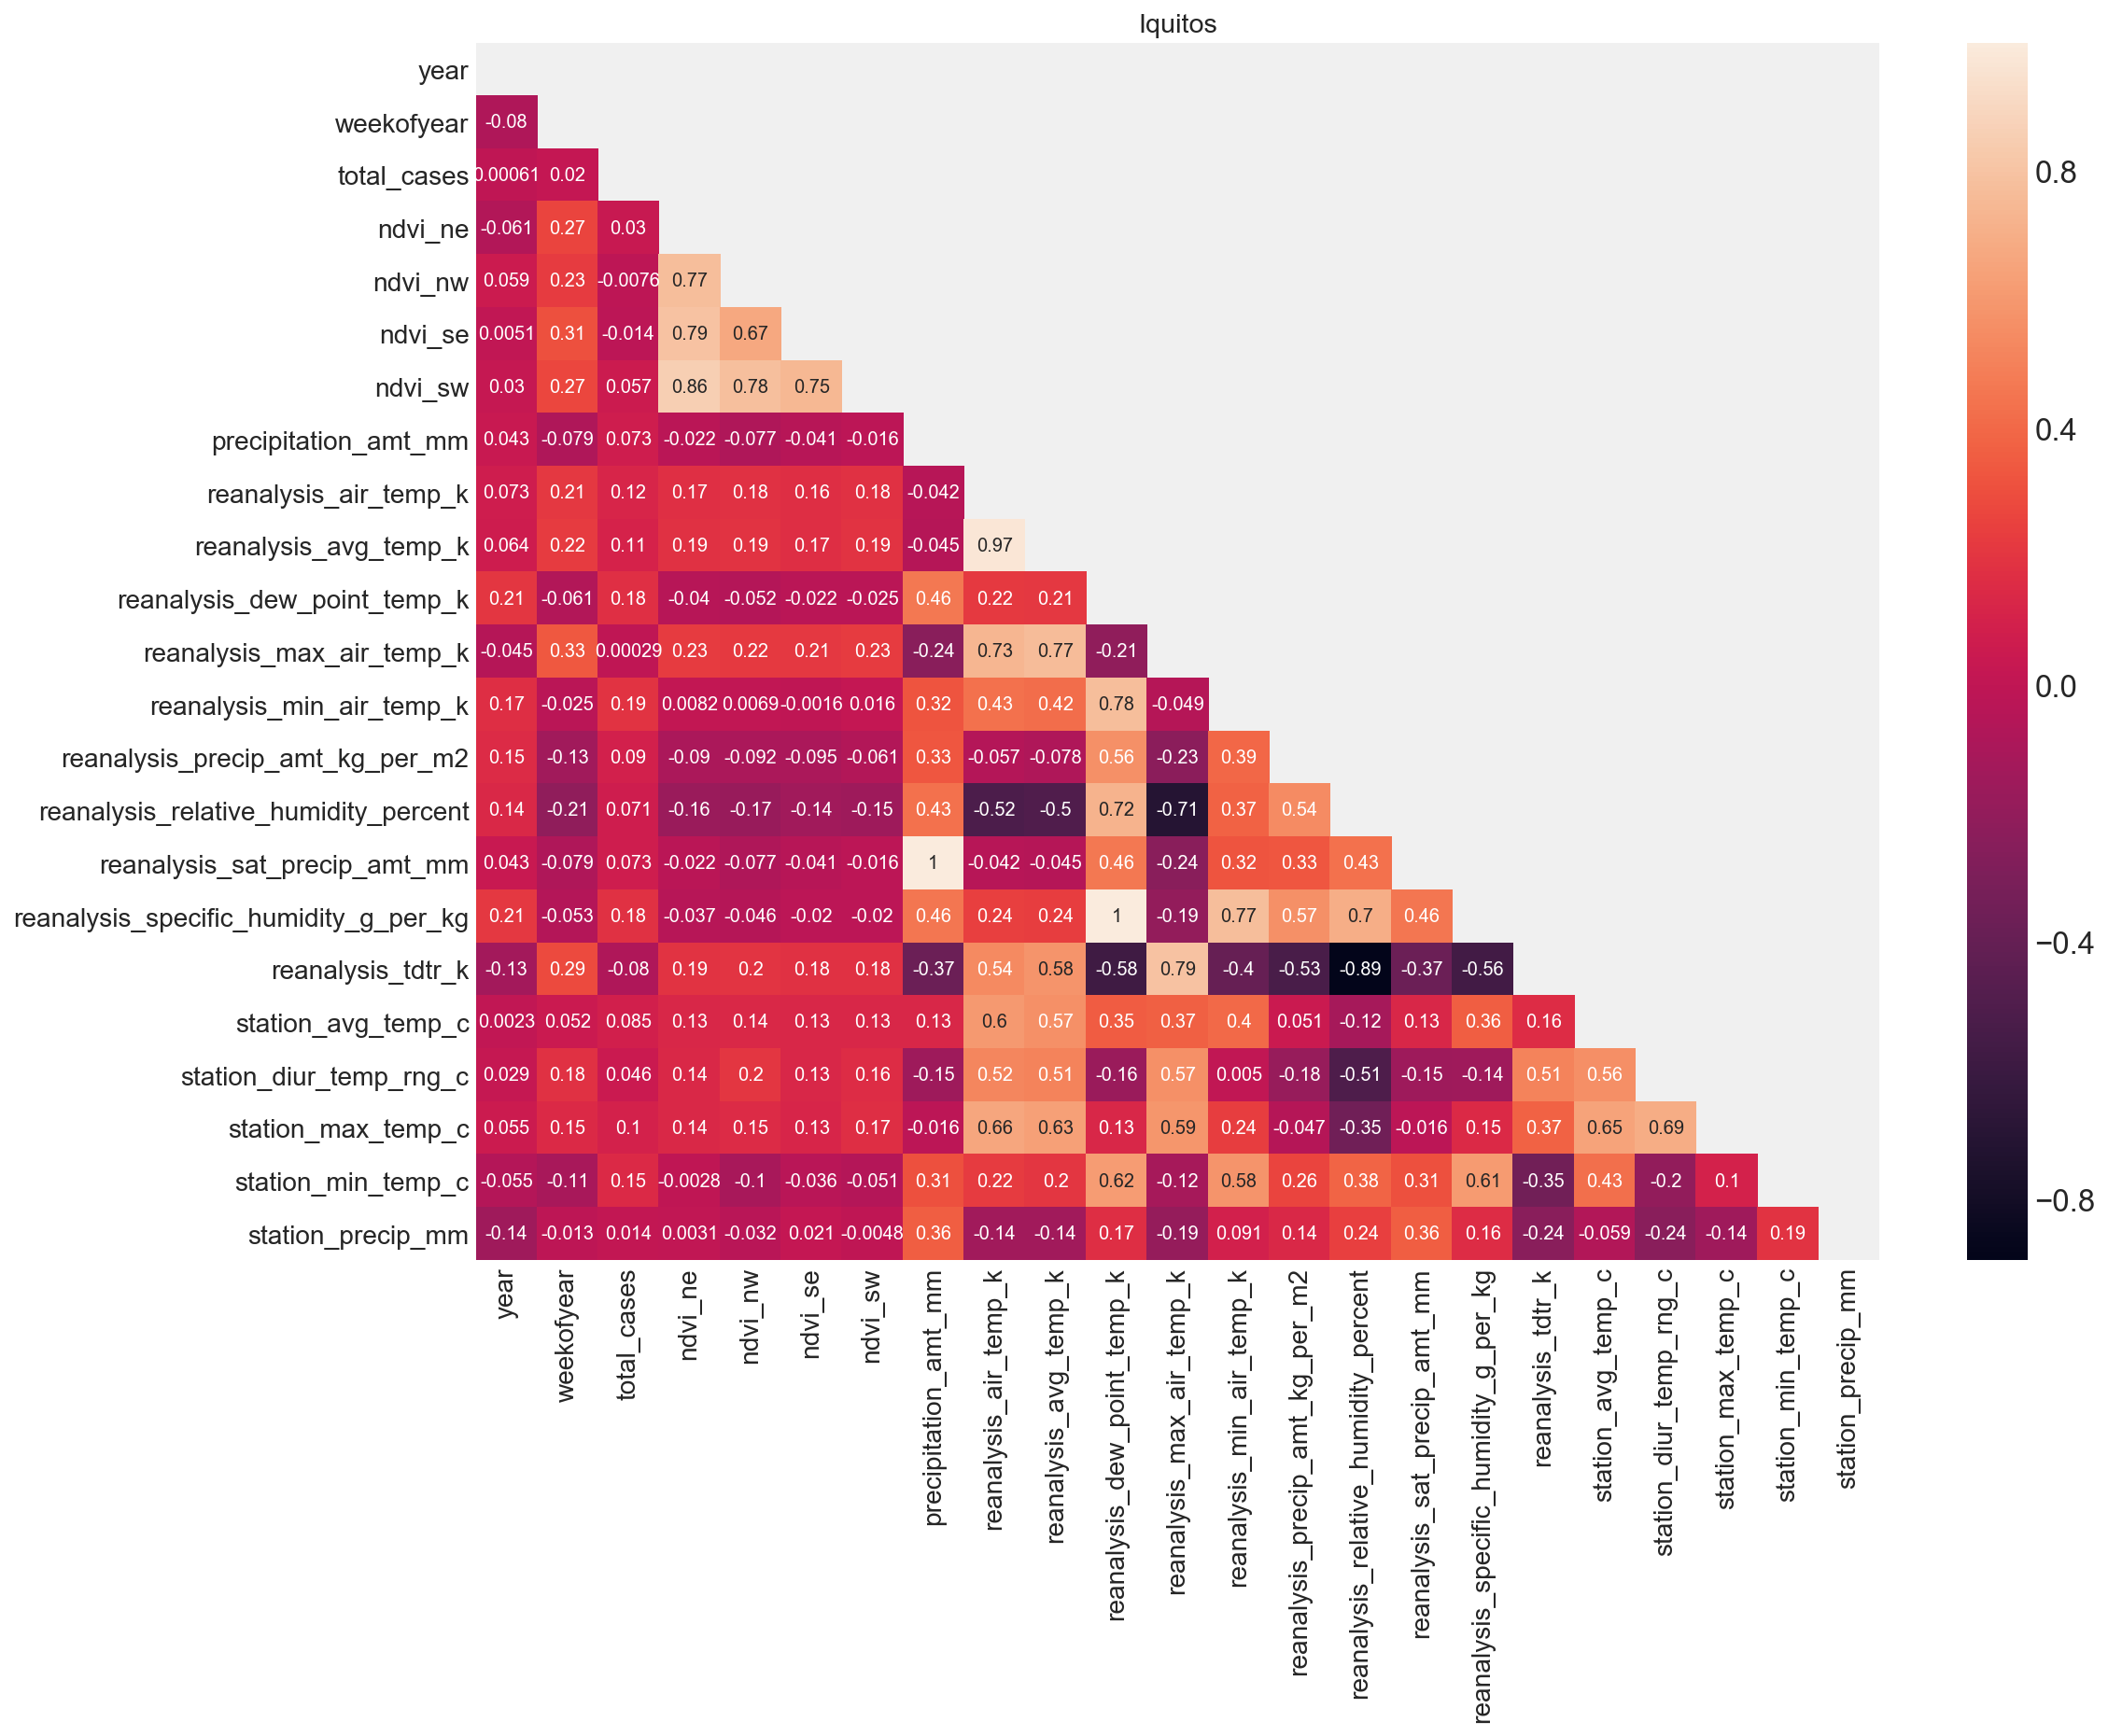

In [18]:
#Heatmap of only Iquitos
iqcorr = iquitos.corr()

fig, ax = plt.subplots(figsize=(15,12))

mask = np.zeros_like(iqcorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(iqcorr, mask=mask, ax=ax, annot=True)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

ax.set_title('Iquitos')
plt.show()

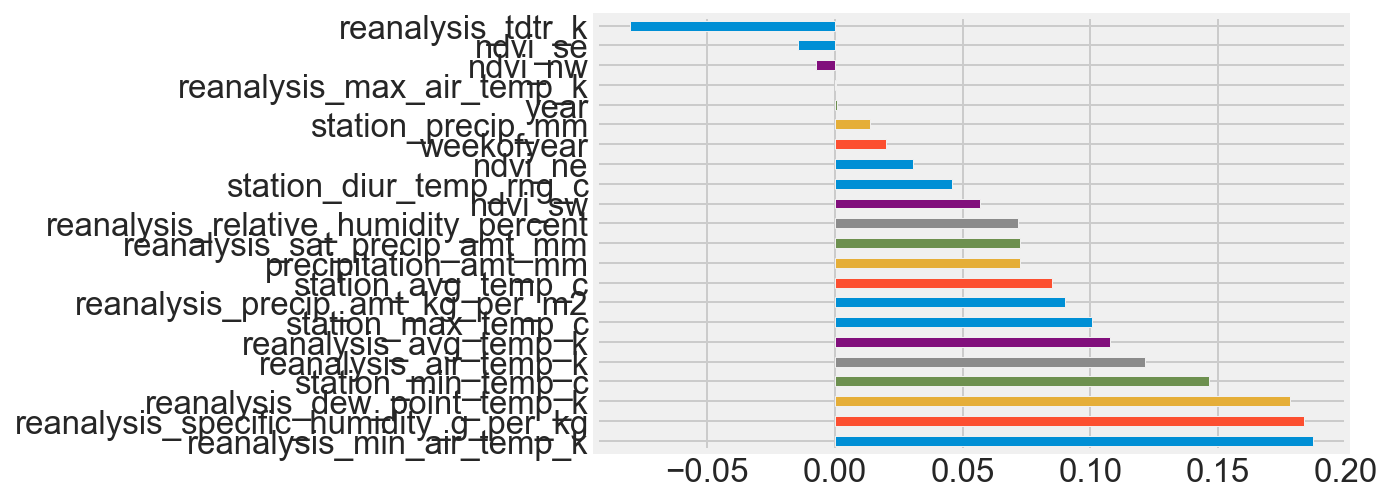

In [19]:
#Again very week correlation with the target. Max scale is 0.2
(iqcorr
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

In [20]:
#Will try a simple Linear regression model with all the features. Expecting a terrible score as sorting correlation 
#was tiny on scale.

In [21]:
#Model 1: Iquitos data only from 2002-2010. Linear Regression: all features.
X = iquitos[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']]
y = iquitos.total_cases

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=30)

In [23]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [24]:
model = LinearRegression()

# get cross validated scores
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
model.fit(X_train, y_train)
print("Training Score:", model.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", model.score(X_test, y_test))

Cross-validated training scores: [-0.11792877  0.01968835 -0.60340245  0.00205005 -0.15534371]
Mean cross-validated training score: -0.17098730688341007
Training Score: 0.08725738095780244
Test Score: -0.035986188347260084


In [25]:
#Model 2: San Juan data from 1990-2008. Linear Regression: all features.
X = san_juan[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']]
y = san_juan.total_cases

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=50)

In [27]:
# standardize the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [28]:
model = LinearRegression()

# get cross validated scores
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
model.fit(X_train, y_train)
print("Training Score:", model.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", model.score(X_test, y_test))

#Better score on the mean CV vs the iquitos data which was expected as Iquitos data does not seem complete. 

Cross-validated training scores: [ 0.14638826 -0.15884922  0.17089099  0.19523404  0.10566527]
Mean cross-validated training score: 0.09186586760272397
Training Score: 0.189325520057244
Test Score: -0.042242526345440234


In [29]:
df_coef = pd.DataFrame({'Predictors San Juan': X.columns, 
              'coef': model.coef_, 
              'abs_coef':abs(model.coef_)}).sort_values('abs_coef', ascending=False)
df_coef

,Predictors San Juan,coef,abs_coef
5,reanalysis_air_temp_k,84.712289,84.712289
7,reanalysis_dew_point_temp_k,-78.518173,78.518173
6,reanalysis_avg_temp_k,-71.283880,71.283880
13,reanalysis_specific_humidity_g_per_kg,61.394094,61.394094
2,ndvi_se,-30.985165,30.985165
3,ndvi_sw,25.288528,25.288528
8,reanalysis_max_air_temp_k,18.270416,18.270416
15,station_avg_temp_c,-13.978179,13.978179
11,reanalysis_relative_humidity_percent,11.004404,11.004404
14,reanalysis_tdtr_k,-7.054441,7.054441


In [32]:
#Model 2.1: San Juan data from 1990-2008. Linear Regression: All features apart from 'reanalysis_avg_temp_k'
#&'reanalysis_dew_point_temp_k'.
X = san_juan[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']]
y = san_juan.total_cases

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=50)

In [34]:
# standardize the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [35]:
model = LinearRegression()

# get cross validated scores
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
model.fit(X_train, y_train)
print("Training Score:", model.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", model.score(X_test, y_test))

#slightly better score, but irrelevant on the big picture.

Cross-validated training scores: [ 0.147517   -0.15868539  0.17125729  0.19579886  0.1053468 ]
Mean cross-validated training score: 0.09224691349522576
Training Score: 0.18901234459669447
Test Score: -0.041655246453484285


In [36]:
pd.DataFrame({'Predictors San Juan': X.columns, 
              'coef': model.coef_, 
              'abs_coef':abs(model.coef_)}).sort_values('abs_coef', ascending=False)

,Predictors San Juan,coef,abs_coef
6,reanalysis_avg_temp_k,-71.192676,71.192676
12,reanalysis_specific_humidity_g_per_kg,63.651838,63.651838
2,ndvi_se,-31.059130,31.059130
3,ndvi_sw,25.517110,25.517110
10,reanalysis_relative_humidity_percent,-25.007947,25.007947
5,reanalysis_air_temp_k,23.178293,23.178293
7,reanalysis_max_air_temp_k,18.722552,18.722552
14,station_avg_temp_c,-13.153908,13.153908
13,reanalysis_tdtr_k,-7.000167,7.000167
8,reanalysis_min_air_temp_k,5.864496,5.864496


In [37]:
#Testing to see if we can lag the data to help predict.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

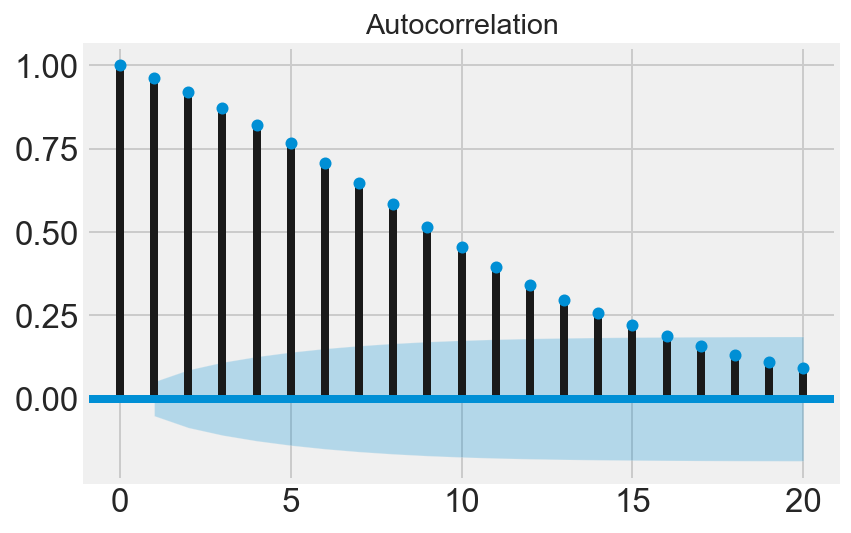

In [38]:
plot_acf(dengue_merged['total_cases'], lags=20)
plt.show()

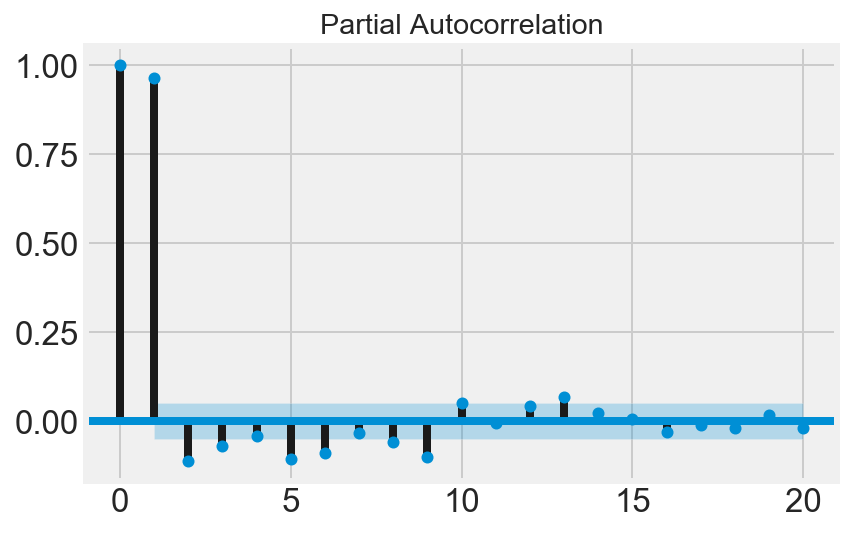

In [39]:
# Strong correlation from one row to another.
plot_pacf(dengue_merged['total_cases'], lags=20)
plt.show()

In [40]:
san_juan.head()

,city,year,weekofyear,total_cases,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,4,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,5,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,4,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,3,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,6,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [41]:
sj_shift1 = san_juan

In [42]:
sj_shift1.head()

,city,year,weekofyear,total_cases,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,4,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,5,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,4,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,3,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,6,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [43]:
sj_shift1['TC_1wk_ago'] = sj_shift1['total_cases'].shift(1)

In [44]:
sj_shift1.dropna(inplace=True)

In [45]:
sj_shift1.head()

,city,year,weekofyear,total_cases,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,TC_1wk_ago
1,sj,1990,19,5,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,4.0
2,sj,1990,20,4,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,5.0
3,sj,1990,21,3,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,4.0
4,sj,1990,22,6,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,3.0
5,sj,1990,23,2,1990-06-04,0.196200,0.174850,0.254314,0.181743,9.58,...,79.891429,9.58,17.212857,2.100000,28.114286,6.942857,34.4,23.9,39.1,6.0


In [46]:
#Try with Autoregression Model, which will take the previous week 'total_cases' as a feature: 'TC_1wk_ago'.
#Model 3: TARGET: 'total_cases'. Dataset: San Juan.
X = sj_shift1[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'TC_1wk_ago']]
y = sj_shift1.total_cases

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3)

In [48]:
# standardize the data and fit
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [49]:
model = LinearRegression()

# get cross validated scores
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
model.fit(X_train, y_train)
print("Training Score:", model.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", model.score(X_test, y_test))

Cross-validated training scores: [0.95969275 0.90487318 0.87568589 0.94887273 0.84697297]
Mean cross-validated training score: 0.90721950394361
Training Score: 0.9389303416968959
Test Score: 0.9131128766157114


In [50]:
#Unsurprisingly the new column "TC_AR1" is the most important feature.
pd.DataFrame({'Predictors San Juan': X.columns, 
              'coef': model.coef_, 
              'abs_coef':abs(model.coef_)}).sort_values('abs_coef', ascending=False)

,Predictors San Juan,coef,abs_coef
20,TC_1wk_ago,47.999957,47.999957
6,reanalysis_avg_temp_k,6.383901,6.383901
7,reanalysis_dew_point_temp_k,-4.628749,4.628749
13,reanalysis_specific_humidity_g_per_kg,-4.611972,4.611972
15,station_avg_temp_c,4.251739,4.251739
11,reanalysis_relative_humidity_percent,3.694809,3.694809
5,reanalysis_air_temp_k,-1.386703,1.386703
8,reanalysis_max_air_temp_k,1.011522,1.011522
2,ndvi_se,0.998044,0.998044
0,ndvi_ne,-0.877388,0.877388


In [51]:
iq_shift1 = iquitos

In [52]:
iq_shift1['TC_1wk_ago'] = iq_shift1['total_cases'].shift(1)

In [53]:
iq_shift1.dropna(inplace=True)

In [54]:
iq_shift1.head()

,city,year,weekofyear,total_cases,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,TC_1wk_ago
1015,iq,2002,2,11,2002-01-08,0.327583,0.375917,0.410267,0.383333,64.79,...,76.602857,64.79,16.482857,11.400000,28.966667,11.933333,35.4,21.0,7.1,4.0
1016,iq,2002,3,16,2002-01-15,0.241086,0.145650,0.278029,0.197643,22.77,...,75.204286,22.77,16.157143,12.128571,28.800000,12.766667,36.0,22.0,5.0,11.0
1017,iq,2002,4,23,2002-01-22,0.104129,0.148329,0.112186,0.141914,121.07,...,81.527143,121.07,16.677143,10.214286,27.940000,11.800000,35.8,21.0,18.0,16.0
1018,iq,2002,5,12,2002-01-29,0.104129,0.148329,0.112186,0.141914,59.40,...,96.267143,59.40,17.690000,5.228571,26.300000,9.700000,32.5,20.8,120.2,23.0
1019,iq,2002,6,14,2002-02-05,0.184917,0.173329,0.168743,0.184429,4.68,...,96.641429,4.68,16.722857,5.185714,26.625000,9.725000,34.0,20.8,70.4,12.0


In [55]:
#Try with Autoregression Model, which will take the previous week 'total_cases' as a feature: 'TC_1wk_ago'.
#Model 4: TARGET: 'total_cases'. Dataset: Iquitos.
X = iq_shift1[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'TC_1wk_ago']]
y = iq_shift1.total_cases

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=30)

In [57]:
# standardize the data and fit
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [58]:
from sklearn.ensemble import RandomForestRegressor

In [59]:
model = RandomForestRegressor(n_estimators=100)

scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

Cross-validated training scores: [ 0.07676403  0.38693131  0.49189658  0.47943516 -0.71847323]
Mean cross-validated training score: 0.14331076902870982
0.9062528980976929
0.4578621725918821


In [60]:
model = LinearRegression()

# get cross validated scores
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
model.fit(X_train, y_train)
print("Training Score:", model.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", model.score(X_test, y_test))

Cross-validated training scores: [ 0.48072059  0.66118718  0.45401843  0.57090215 -1.96149663]
Mean cross-validated training score: 0.041066344098515464
Training Score: 0.5475434462474289
Test Score: 0.4810099562706628


In [61]:
#Unsurprisingly the new column "TC_AR1" is the most important feature, but less important than in San Juan.
#Model results not as good with Iquitos data vs San Juan data.
pd.DataFrame({'Predictors Iquitos': X.columns, 
              'coef': model.coef_, 
              'abs_coef':abs(model.coef_)}).sort_values('abs_coef', ascending=False)

,Predictors Iquitos,coef,abs_coef
20,TC_1wk_ago,8.466528,8.466528
13,reanalysis_specific_humidity_g_per_kg,-7.519626,7.519626
7,reanalysis_dew_point_temp_k,5.196185,5.196185
5,reanalysis_air_temp_k,2.991385,2.991385
3,ndvi_sw,2.147963,2.147963
14,reanalysis_tdtr_k,-1.464918,1.464918
11,reanalysis_relative_humidity_percent,1.277159,1.277159
18,station_min_temp_c,1.093601,1.093601
15,station_avg_temp_c,-0.952788,0.952788
16,station_diur_temp_rng_c,0.850994,0.850994


In [62]:
#Adding another feature of shifting the total cases for san juan by 4 weeks.
sj_shift1['TC_4wk_ago'] = sj_shift1['total_cases'].shift(4)

In [63]:
sj_shift1.head()

,city,year,weekofyear,total_cases,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,TC_1wk_ago,TC_4wk_ago
1,sj,1990,19,5,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,...,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,4.0,NaN
2,sj,1990,20,4,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,...,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,5.0,NaN
3,sj,1990,21,3,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,...,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,4.0,NaN
4,sj,1990,22,6,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,...,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,3.0,NaN
5,sj,1990,23,2,1990-06-04,0.196200,0.174850,0.254314,0.181743,9.58,...,9.58,17.212857,2.100000,28.114286,6.942857,34.4,23.9,39.1,6.0,5.0


In [64]:
sj_shift1.dropna(inplace=True)

In [65]:
sj_shift1.head()

,city,year,weekofyear,total_cases,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,TC_1wk_ago,TC_4wk_ago
5,sj,1990,23,2,1990-06-04,0.19620,0.174850,0.254314,0.181743,9.58,...,9.58,17.212857,2.100000,28.114286,6.942857,34.4,23.9,39.1,6.0,5.0
6,sj,1990,24,4,1990-06-11,0.11290,0.092800,0.205071,0.210271,3.48,...,3.48,17.234286,2.042857,27.414286,6.771429,32.2,23.3,29.7,2.0,4.0
7,sj,1990,25,5,1990-06-18,0.07250,0.072500,0.151471,0.133029,151.12,...,151.12,17.977143,1.571429,28.371429,7.685714,33.9,22.8,21.1,4.0,3.0
8,sj,1990,26,10,1990-06-25,0.10245,0.146175,0.125571,0.123600,19.32,...,19.32,17.790000,1.885714,28.328571,7.385714,33.9,22.8,21.1,5.0,6.0
9,sj,1990,27,6,1990-07-02,0.10245,0.121550,0.160683,0.202567,14.41,...,14.41,18.071429,2.014286,28.328571,6.514286,33.9,24.4,1.1,10.0,2.0


In [66]:
#Model 3.1:San Juan: TARGET: total cases. Added features TC 1wk ago and TC 4wk ago. 
X = sj_shift1[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'TC_1wk_ago', 'TC_4wk_ago']]
y = sj_shift1.total_cases

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3)

In [68]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [69]:
ridgeCV = RidgeCV(alphas=np.logspace(-3, 3, 300), cv=5)
ridgeCV.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000e-03, 1.04729e-03, ..., 9.54846e+02, 1.00000e+03]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [70]:
print(ridgeCV.alpha_)
print(ridgeCV.score(X_test, y_test))

5.923457145875806
0.8978995951522581


In [71]:
model = Ridge(alpha=ridgeCV.alpha_)
model.fit(X_train, y_train)
# get cross validated scores
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
print("Training Score:", model.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", model.score(X_test, y_test))

Cross-validated training scores: [0.96547353 0.89640471 0.88621324 0.93707792 0.91519133]
Mean cross-validated training score: 0.9200721462148211
Training Score: 0.9394227263385747
Test Score: 0.8978995951522581


In [72]:
#I was quite surprised by how quickly the correlation dropped for only 4weeks shift. 
pd.DataFrame({'Predictor San Juan': X.columns, 
              'coef': model.coef_, 
              'abs_coef':abs(model.coef_)}).sort_values('abs_coef', ascending=False)

,Predictor San Juan,coef,abs_coef
20,TC_1wk_ago,52.311142,52.311142
15,station_avg_temp_c,2.788869,2.788869
21,TC_4wk_ago,-1.923233,1.923233
8,reanalysis_max_air_temp_k,1.464811,1.464811
9,reanalysis_min_air_temp_k,-1.184828,1.184828
16,station_diur_temp_rng_c,-1.029983,1.029983
0,ndvi_ne,-0.866289,0.866289
18,station_min_temp_c,-0.811359,0.811359
14,reanalysis_tdtr_k,-0.756284,0.756284
1,ndvi_nw,0.645942,0.645942


In [73]:
iq_shift1['TC_4wk_ago'] = iq_shift1['total_cases'].shift(4)

In [74]:
iq_shift1.head()

,city,year,weekofyear,total_cases,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,TC_1wk_ago,TC_4wk_ago
1015,iq,2002,2,11,2002-01-08,0.327583,0.375917,0.410267,0.383333,64.79,...,64.79,16.482857,11.400000,28.966667,11.933333,35.4,21.0,7.1,4.0,NaN
1016,iq,2002,3,16,2002-01-15,0.241086,0.145650,0.278029,0.197643,22.77,...,22.77,16.157143,12.128571,28.800000,12.766667,36.0,22.0,5.0,11.0,NaN
1017,iq,2002,4,23,2002-01-22,0.104129,0.148329,0.112186,0.141914,121.07,...,121.07,16.677143,10.214286,27.940000,11.800000,35.8,21.0,18.0,16.0,NaN
1018,iq,2002,5,12,2002-01-29,0.104129,0.148329,0.112186,0.141914,59.40,...,59.40,17.690000,5.228571,26.300000,9.700000,32.5,20.8,120.2,23.0,NaN
1019,iq,2002,6,14,2002-02-05,0.184917,0.173329,0.168743,0.184429,4.68,...,4.68,16.722857,5.185714,26.625000,9.725000,34.0,20.8,70.4,12.0,11.0


In [75]:
iq_shift1.dropna(inplace=True)

In [76]:
#Model 4.1:Iquitos: TARGET: total cases. Added features TC 1wk ago and TC4 wk ago. 
X = iq_shift1[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'TC_1wk_ago', 'TC_4wk_ago']]
y = iq_shift1.total_cases

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3)

In [78]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [79]:
ridgeCV = RidgeCV(alphas=np.logspace(-3, 3, 300), cv=5)
ridgeCV.fit(X_train, y_train)

/Users/nclendinnen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RidgeCV(alphas=array([1.00000e-03, 1.04729e-03, ..., 9.54846e+02, 1.00000e+03]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [80]:
print(ridgeCV.alpha_)
print(ridgeCV.score(X_test, y_test))

108.84019160690055
0.5140212981871048


In [81]:
model = Ridge(alpha=ridgeCV.alpha_)
model.fit(X_train, y_train)
# get cross validated scores
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
print("Training Score:", model.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", model.score(X_test, y_test))

Cross-validated training scores: [0.51154326 0.52638155 0.36703729 0.55753981 0.37994812]
Mean cross-validated training score: 0.46849000539654695
Training Score: 0.5264018388539364
Test Score: 0.5140212981871048


In [82]:
#On the Iquitos datset the 4 shift actually is quite useful since it's other features data does not seem that helpful.
pd.DataFrame({'Predictor Iquitos': X.columns, 
              'coef': model.coef_, 
              'abs_coef':abs(model.coef_)}).sort_values('abs_coef', ascending=False)

,Predictor Iquitos,coef,abs_coef
20,TC_1wk_ago,5.896933,5.896933
21,TC_4wk_ago,1.622967,1.622967
3,ndvi_sw,0.997759,0.997759
2,ndvi_se,-0.493186,0.493186
16,station_diur_temp_rng_c,0.469789,0.469789
18,station_min_temp_c,0.447692,0.447692
14,reanalysis_tdtr_k,-0.406835,0.406835
9,reanalysis_min_air_temp_k,0.367908,0.367908
17,station_max_temp_c,0.334061,0.334061
1,ndvi_nw,-0.322175,0.322175


In [83]:
#Trying 52 weeks on San Juan as there is a visible annual pattern. The autocorrelation suggested there would be none but thought I would try.
sj_shift1['TC_52wk_ago'] = sj_shift1['total_cases'].shift(52)

In [84]:
sj_shift1.head()

,city,year,weekofyear,total_cases,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,TC_1wk_ago,TC_4wk_ago,TC_52wk_ago
5,sj,1990,23,2,1990-06-04,0.19620,0.174850,0.254314,0.181743,9.58,...,17.212857,2.100000,28.114286,6.942857,34.4,23.9,39.1,6.0,5.0,NaN
6,sj,1990,24,4,1990-06-11,0.11290,0.092800,0.205071,0.210271,3.48,...,17.234286,2.042857,27.414286,6.771429,32.2,23.3,29.7,2.0,4.0,NaN
7,sj,1990,25,5,1990-06-18,0.07250,0.072500,0.151471,0.133029,151.12,...,17.977143,1.571429,28.371429,7.685714,33.9,22.8,21.1,4.0,3.0,NaN
8,sj,1990,26,10,1990-06-25,0.10245,0.146175,0.125571,0.123600,19.32,...,17.790000,1.885714,28.328571,7.385714,33.9,22.8,21.1,5.0,6.0,NaN
9,sj,1990,27,6,1990-07-02,0.10245,0.121550,0.160683,0.202567,14.41,...,18.071429,2.014286,28.328571,6.514286,33.9,24.4,1.1,10.0,2.0,NaN


In [85]:
sj_shift1.dropna(inplace=True)

In [86]:
#Model 3.2: San Juan: TARGET: total cases. Added features TC 1wk ago, TC4 wk ago & 'TC_12wk_ago'. 
X = sj_shift1[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'TC_1wk_ago', 'TC_4wk_ago', 'TC_52wk_ago']]
y = sj_shift1.total_cases

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3)

In [88]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [89]:
ridgeCV = RidgeCV(alphas=np.logspace(-3, 3, 300), cv=5)
ridgeCV.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000e-03, 1.04729e-03, ..., 9.54846e+02, 1.00000e+03]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [90]:
print(ridgeCV.alpha_)
print(ridgeCV.score(X_test, y_test))

7.815856707684091
0.9489075848073674


In [91]:
model = Ridge(alpha=ridgeCV.alpha_)
model.fit(X_train, y_train)
# get cross validated scores
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
print("Training Score:", model.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", model.score(X_test, y_test))

Cross-validated training scores: [0.88231572 0.94409502 0.91122887 0.92268896 0.91690827]
Mean cross-validated training score: 0.9154473691939853
Training Score: 0.9294679132415419
Test Score: 0.9489075848073674


In [92]:
pd.DataFrame({'Predictor San Juan': X.columns, 
              'coef': model.coef_, 
              'abs_coef':abs(model.coef_)}).sort_values('abs_coef', ascending=False)

,Predictor San Juan,coef,abs_coef
20,TC_1wk_ago,48.726874,48.726874
15,station_avg_temp_c,2.426025,2.426025
6,reanalysis_avg_temp_k,-1.406748,1.406748
8,reanalysis_max_air_temp_k,0.959933,0.959933
22,TC_52wk_ago,-0.563483,0.563483
18,station_min_temp_c,0.522551,0.522551
9,reanalysis_min_air_temp_k,-0.476505,0.476505
16,station_diur_temp_rng_c,-0.461312,0.461312
19,station_precip_mm,0.460297,0.460297
11,reanalysis_relative_humidity_percent,-0.457397,0.457397


In [93]:
#Neuron network on Iquitos train dataset.

In [94]:
from sklearn import metrics

In [95]:
metrics.mean_squared_error(y_test,model.predict(X_test))

169.1534947170573

In [96]:
metrics.r2_score(y_test,model.predict(X_test))

0.9382750781497183

In [97]:
print(model.coef_)
print(model.intercept_)

[-5.52858111e-01  3.99611699e-01  7.07054338e-01 -3.37726373e-01
  4.07861774e-01 -1.40827995e+00  9.91299605e-01 -4.26102948e-02
  1.91770982e-01 -2.27679063e+00 -1.75317941e-01 -3.73860660e-01
  4.07861774e-01  8.53744019e-01 -9.07875580e-02  2.97641273e+00
 -8.80273573e-01  2.61810746e-01 -1.31646236e-01 -5.29808907e-01
  5.17353606e+01 -1.93963595e+00 -1.52253431e+00]
35.11836734693879


In [98]:
from sklearn.neural_network import MLPRegressor

In [99]:
nnet = MLPRegressor(hidden_layer_sizes=1,solver='lbfgs',activation='relu',max_iter=1000,random_state=1)
nnet.fit(X_train,y_train)
metrics.mean_squared_error(y_test,nnet.predict(X_test))

171.14625162671456

In [100]:
print(nnet.coefs_)

[array([[-1.38200020e-01],
       [ 1.29820009e-01],
       [ 2.08681756e-01],
       [-1.41740946e-01],
       [ 7.29516076e-02],
       [-6.67357001e+00],
       [ 7.88807363e-01],
       [ 6.28942314e+00],
       [-3.28811348e-02],
       [-6.15045826e-01],
       [-2.63283629e-02],
       [-3.39939353e+00],
       [ 1.30642158e-01],
       [ 1.36231579e+00],
       [ 1.91003775e-02],
       [ 8.91029877e-01],
       [-1.90093837e-01],
       [ 1.29342835e-02],
       [-1.69321162e-03],
       [-9.64026024e-02],
       [ 1.11611004e+01],
       [-5.79745818e-01],
       [-2.73748002e-01]]), array([[4.72457615]])]


In [101]:
nnet.intercepts_

[array([6.05032113]), array([6.20413114])]

In [102]:
print((nnet.coefs_[0]*nnet.coefs_[1]).flatten())

[-6.52936519e-01  6.13344519e-01  9.85932849e-01 -6.69665894e-01
  3.44665425e-01 -3.15297897e+01  3.72678046e+00  2.97148586e+01
 -1.55349425e-01 -2.90583084e+00 -1.24390355e-01 -1.60606936e+01
  6.17228826e-01  6.43636472e+00  9.02411882e-02  4.20973851e+00
 -8.98112807e-01  6.11090074e-02 -7.99970724e-03 -4.55461436e-01
  5.27314688e+01 -2.73905327e+00 -1.29334328e+00]


In [103]:
print(model.coef_-(nnet.coefs_[0]*nnet.coefs_[1]).flatten())

[ 1.00078408e-01 -2.13732819e-01 -2.78878512e-01  3.31939521e-01
  6.31963488e-02  3.01215098e+01 -2.73548085e+00 -2.97574689e+01
  3.47120407e-01  6.29040209e-01 -5.09275854e-02  1.56868329e+01
 -2.09367052e-01 -5.58262070e+00 -1.81028746e-01 -1.23332577e+00
  1.78392337e-02  2.00701739e-01 -1.23646529e-01 -7.43474703e-02
 -9.96108198e-01  7.99417315e-01 -2.29191029e-01]


In [104]:
print(nnet.intercepts_[0]*nnet.coefs_[1]+nnet.intercepts_[1])

[[34.78933408]]


In [105]:
print(model.intercept_ - (nnet.intercepts_[0]*nnet.coefs_[1]+nnet.intercepts_[1]))

[[0.32903327]]


In [106]:
nnet = MLPRegressor(hidden_layer_sizes=(10,10,10),solver='lbfgs',activation='relu',random_state=1)
nnet.fit(X_train,y_train)
metrics.mean_squared_error(y_test,nnet.predict(X_test))

246.08542746298755

In [107]:
print([coef.shape for coef in nnet.coefs_])
print(sum([np.prod(coef.shape) for coef in nnet.coefs_]))

[(23, 10), (10, 10), (10, 10), (10, 1)]
440


In [108]:
nnet.predict(X_test)[:10]

array([  2.07052779,  30.15918055,   6.9354463 , 110.89135442,
        31.9429998 ,  48.33429546,   7.82408217,   8.96590712,
        10.07952027, 157.72262431])

In [109]:
nnet.score(X_test,y_test)

0.910202246757871

In [110]:
#SARIMAX

In [111]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [112]:
# Set the DateTime index for Iquitos only.
iquitos['week_start_date'] = pd.to_datetime(iquitos['week_start_date'])
iquitos.set_index('week_start_date', inplace=True)
iquitos.head()

,city,year,weekofyear,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,TC_1wk_ago,TC_4wk_ago
week_start_date,,,,,,,,,,,,,,,,,,,,,
2002-02-05,iq,2002,6,14,0.184917,0.173329,0.168743,0.184429,4.68,295.912857,...,4.68,16.722857,5.185714,26.625,9.725,34.0,20.8,70.4,12.0,11.0
2002-02-12,iq,2002,7,18,0.291971,0.224143,0.305100,0.373271,104.37,297.847143,...,104.37,18.147143,7.700000,27.850,10.725,33.6,20.8,62.8,14.0,16.0
2002-02-19,iq,2002,8,8,0.128800,0.122433,0.095943,0.125171,37.46,297.695714,...,37.46,17.687143,7.728571,27.020,9.780,33.5,21.0,14.0,18.0,23.0
2002-02-26,iq,2002,9,7,0.116200,0.178743,0.089914,0.210414,80.14,297.062857,...,80.14,18.125714,5.814286,26.700,9.600,32.2,20.5,47.6,8.0,12.0
2002-03-05,iq,2002,10,10,0.318367,0.255600,0.266000,0.297383,92.84,298.540000,...,92.84,18.361429,8.971429,27.850,13.200,35.7,21.0,48.3,7.0,14.0


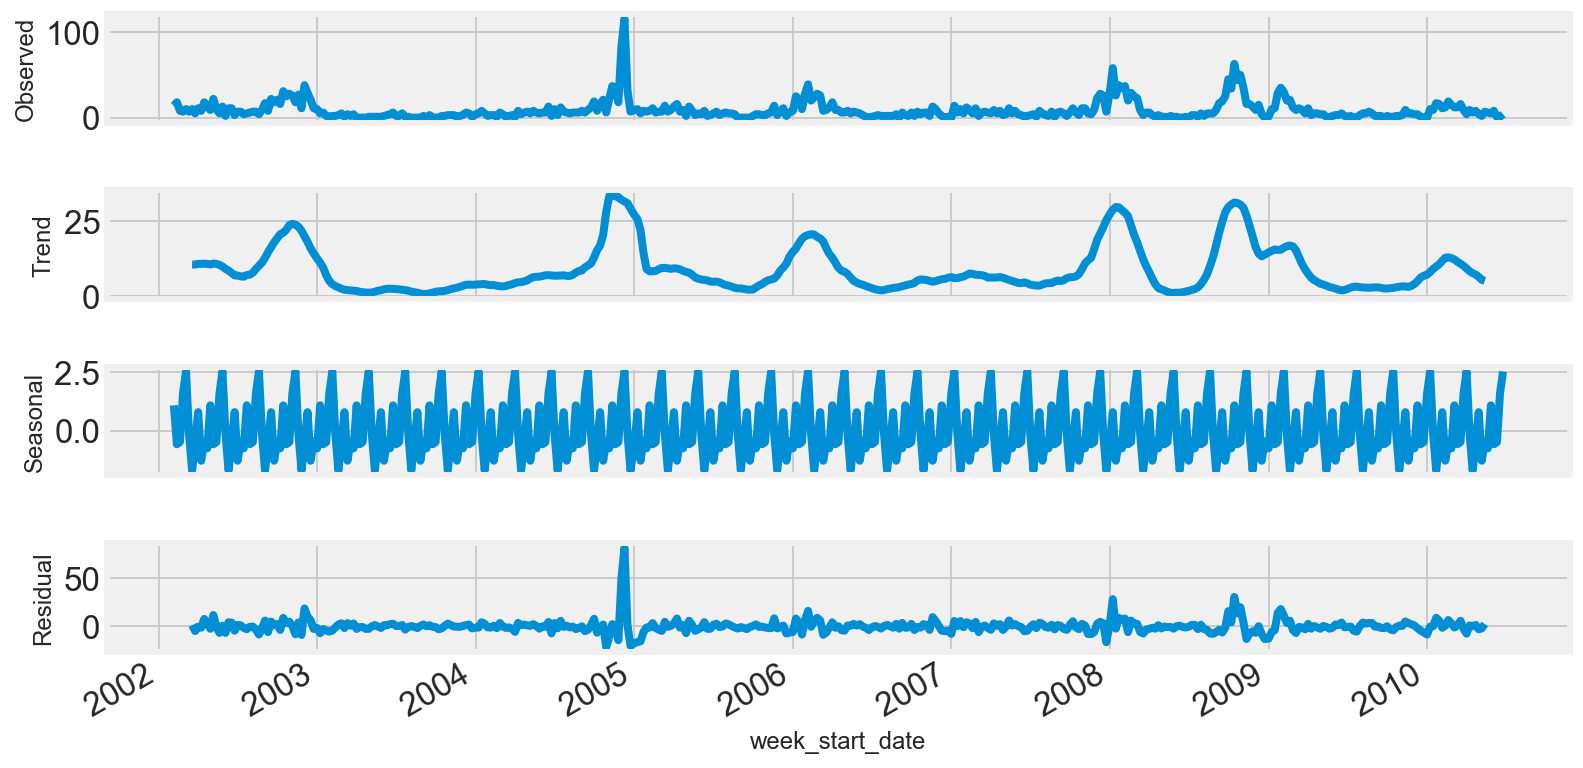

In [113]:
period = 12
decomposition = seasonal_decompose(iquitos.total_cases, freq=period)  
fig = decomposition.plot()  
fig.set_size_inches(12, 6)
plt.show()

In [114]:
import statsmodels.api as sm 

In [115]:
model = sm.tsa.statespace.SARIMAX(iquitos.total_cases,#iquitos[['precipitation_amt_mm']] ,
                                  order=(3,1,3), 
                                  seasonal_order=(1,0,1,52))
results = model.fit(max_iter=1000)
results.summary()

/Users/nclendinnen/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        total_cases   No. Observations:                  437
Model:             SARIMAX(3, 1, 3)x(1, 0, 1, 52)   Log Likelihood               -1493.700
Date:                            Thu, 24 Jan 2019   AIC                           3005.400
Time:                                    22:03:52   BIC                           3042.099
Sample:                                         0   HQIC                          3019.883
                                            - 437                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6402      0.203      3.147      0.002       0.241       1.039
ar.L2         -0.4849      0.204     -2.382      0.017      -0.884      -0.086
ar.L3          0.5078      0.115      4.423      0.000       0.283       0.733
ma.L1         -0.9483      0.223     -4.244      0.000      -1.386      -0.510
ma.L2          0.3937      0.269      1.466      0.143      -0.133       0.920
ma.L3         -0.4369      0.180     -2.429      0.015      -0.789      -0.084
ar.S.L52       0.9662      0.144      6.725      0.000       0.685       1.248
ma.S.L52      -0.9098      0.229     -3.968      0.000      -1.359      -0.460
sigma2        52.9431      3.669     14.428      0.000      45.751      60.135
===================================================================================
Ljung-Box (Q):                       15.81   Jarque-Bera (JB):              7420.78
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                             2.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

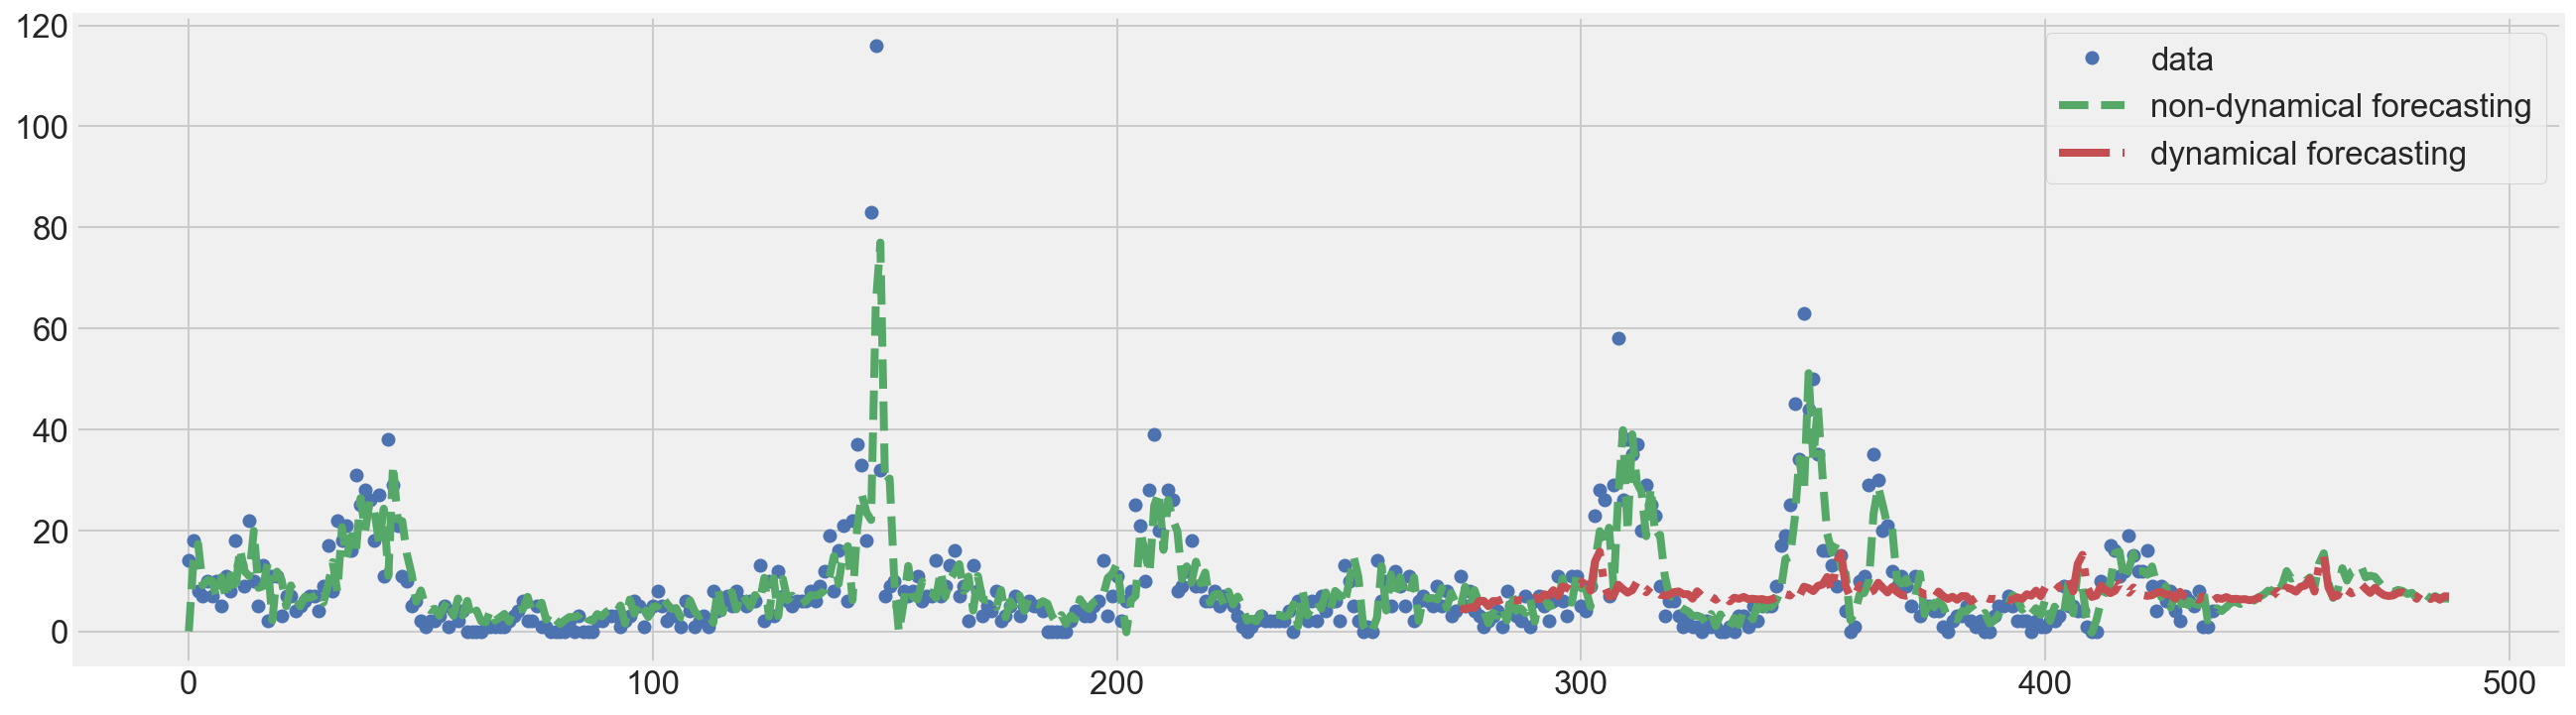

In [116]:
# forecasting
start_p = 600

# two equivalent ways for getting non-dynamical forecasts
# preds = results.forecast(50)
preds = results.predict(start=0,end=len(iquitos)+50,dynamic=False)

preds_dyn = results.predict(start=len(iquitos)-start_p,end=len(iquitos)+50,dynamic=True)
fcast = pd.concat([iquitos.total_cases,preds])
fcast_1 = pd.concat([iquitos.total_cases[:len(iquitos)-start_p],preds_dyn])

preds.shape, preds_dyn.shape, iquitos.total_cases.shape

plt.figure(figsize=(20,6))
plt.plot(iquitos.total_cases.values, 'bo' , preds, 'g--',preds_dyn,'r-.')
plt.legend(['data','non-dynamical forecasting','dynamical forecasting'])
plt.show()

In [117]:
from sklearn.metrics import r2_score, mean_squared_error

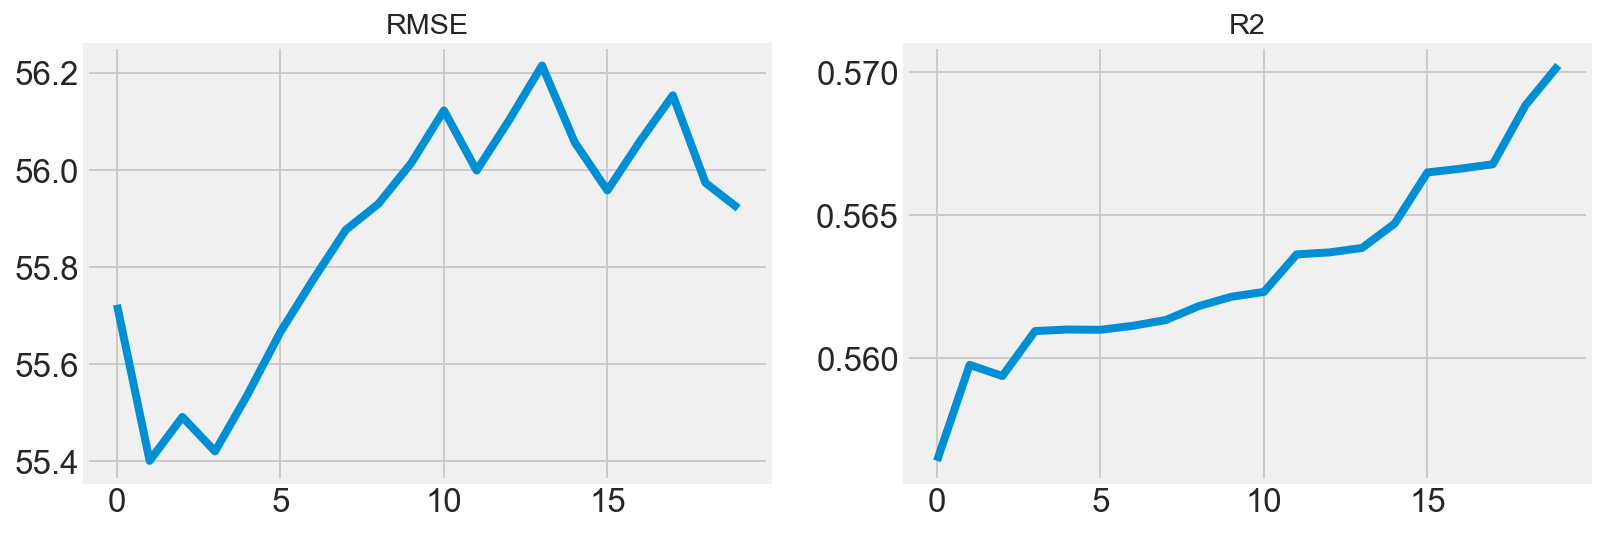

In [118]:
fig, ax = plt.subplots(ncols=2,figsize=(12,4))
ax[0].plot([mean_squared_error(iquitos.total_cases[i:],preds[i:len(iquitos)]) for i in range(20)])
ax[0].set_title('RMSE')
ax[1].plot([r2_score(iquitos.total_cases[i:],preds[i:len(iquitos)]) for i in range(20)])
ax[1].set_title('R2')
plt.show()

In [119]:
# Set the DateTime index: SAN JUAN dataset.
san_juan['week_start_date'] = pd.to_datetime(san_juan['week_start_date'])
san_juan.set_index('week_start_date', inplace=True)
san_juan.head()

,city,year,weekofyear,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,TC_1wk_ago,TC_4wk_ago,TC_12wk_ago
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-08-27,sj,1990,35,28,0.252900,0.330750,0.264171,0.284314,40.94,300.118571,...,18.515714,1.900000,28.657143,6.528571,32.2,24.4,13.7,21.0,17.0,2.0
1990-09-03,sj,1990,36,24,0.235400,0.200025,0.283817,0.230443,28.86,300.530000,...,17.560000,3.471429,28.328571,7.614286,32.8,23.3,14.2,28.0,23.0,4.0
1990-09-10,sj,1990,37,20,0.127967,0.437100,0.123400,0.148283,64.56,300.674286,...,18.777143,2.900000,28.685714,8.057143,33.9,24.4,25.9,24.0,13.0,5.0
1990-09-17,sj,1990,38,40,0.196350,0.182433,0.254829,0.305686,143.73,299.857143,...,17.892857,1.742857,28.242857,8.114286,32.8,23.9,3.3,20.0,21.0,10.0
1990-09-24,sj,1990,39,27,0.116100,0.260900,0.199443,0.244217,51.39,300.427143,...,17.468571,2.257143,28.342857,7.728571,32.8,24.4,15.8,40.0,28.0,6.0


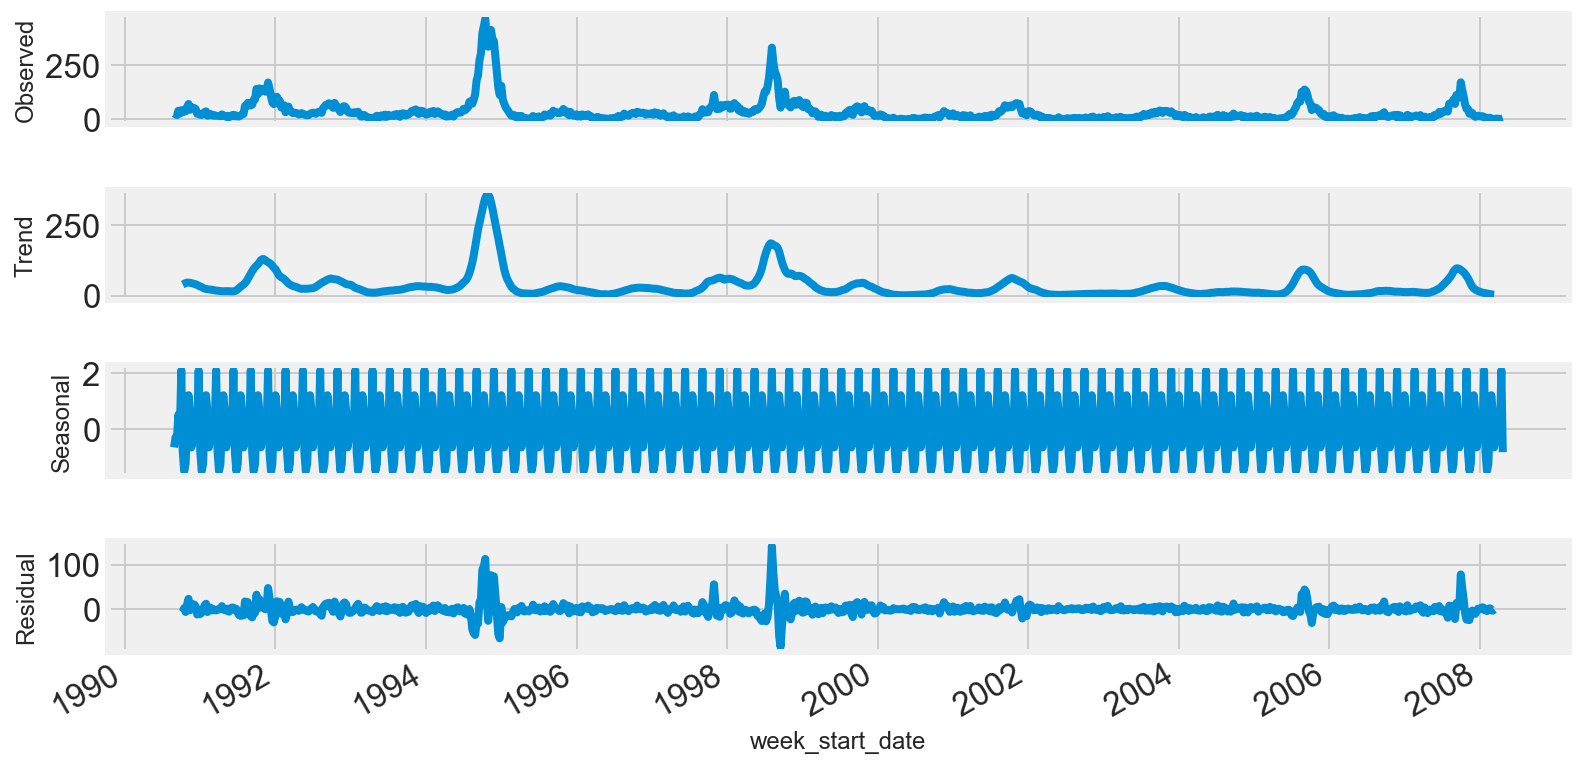

In [120]:
period = 12
decomposition = seasonal_decompose(san_juan.total_cases, freq=period)  
fig = decomposition.plot()  
fig.set_size_inches(12, 6)
plt.show()

In [121]:
model = sm.tsa.statespace.SARIMAX(san_juan.total_cases, 
                                  order=(3,1,1), 
                                  seasonal_order=(1,0,1,52))
results = model.fit(max_iter=1000)
results.summary()

/Users/nclendinnen/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        total_cases   No. Observations:                  919
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 52)   Log Likelihood               -3693.139
Date:                            Thu, 24 Jan 2019   AIC                           7400.279
Time:                                    22:04:40   BIC                           7434.034
Sample:                                         0   HQIC                          7413.161
                                            - 919                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8591      0.031    -27.886      0.000      -0.920      -0.799
ar.L2          0.2035      0.015     13.246      0.000       0.173       0.234
ar.L3          0.0732      0.015      4.726      0.000       0.043       0.104
ma.L1          0.9832      0.030     33.238      0.000       0.925       1.041
ar.S.L52       0.9971      0.091     10.935      0.000       0.818       1.176
ma.S.L52      -0.9890      0.191     -5.169      0.000      -1.364      -0.614
sigma2       180.9910     16.972     10.664      0.000     147.726     214.256
===================================================================================
Ljung-Box (Q):                       63.94   Jarque-Bera (JB):              4243.32
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

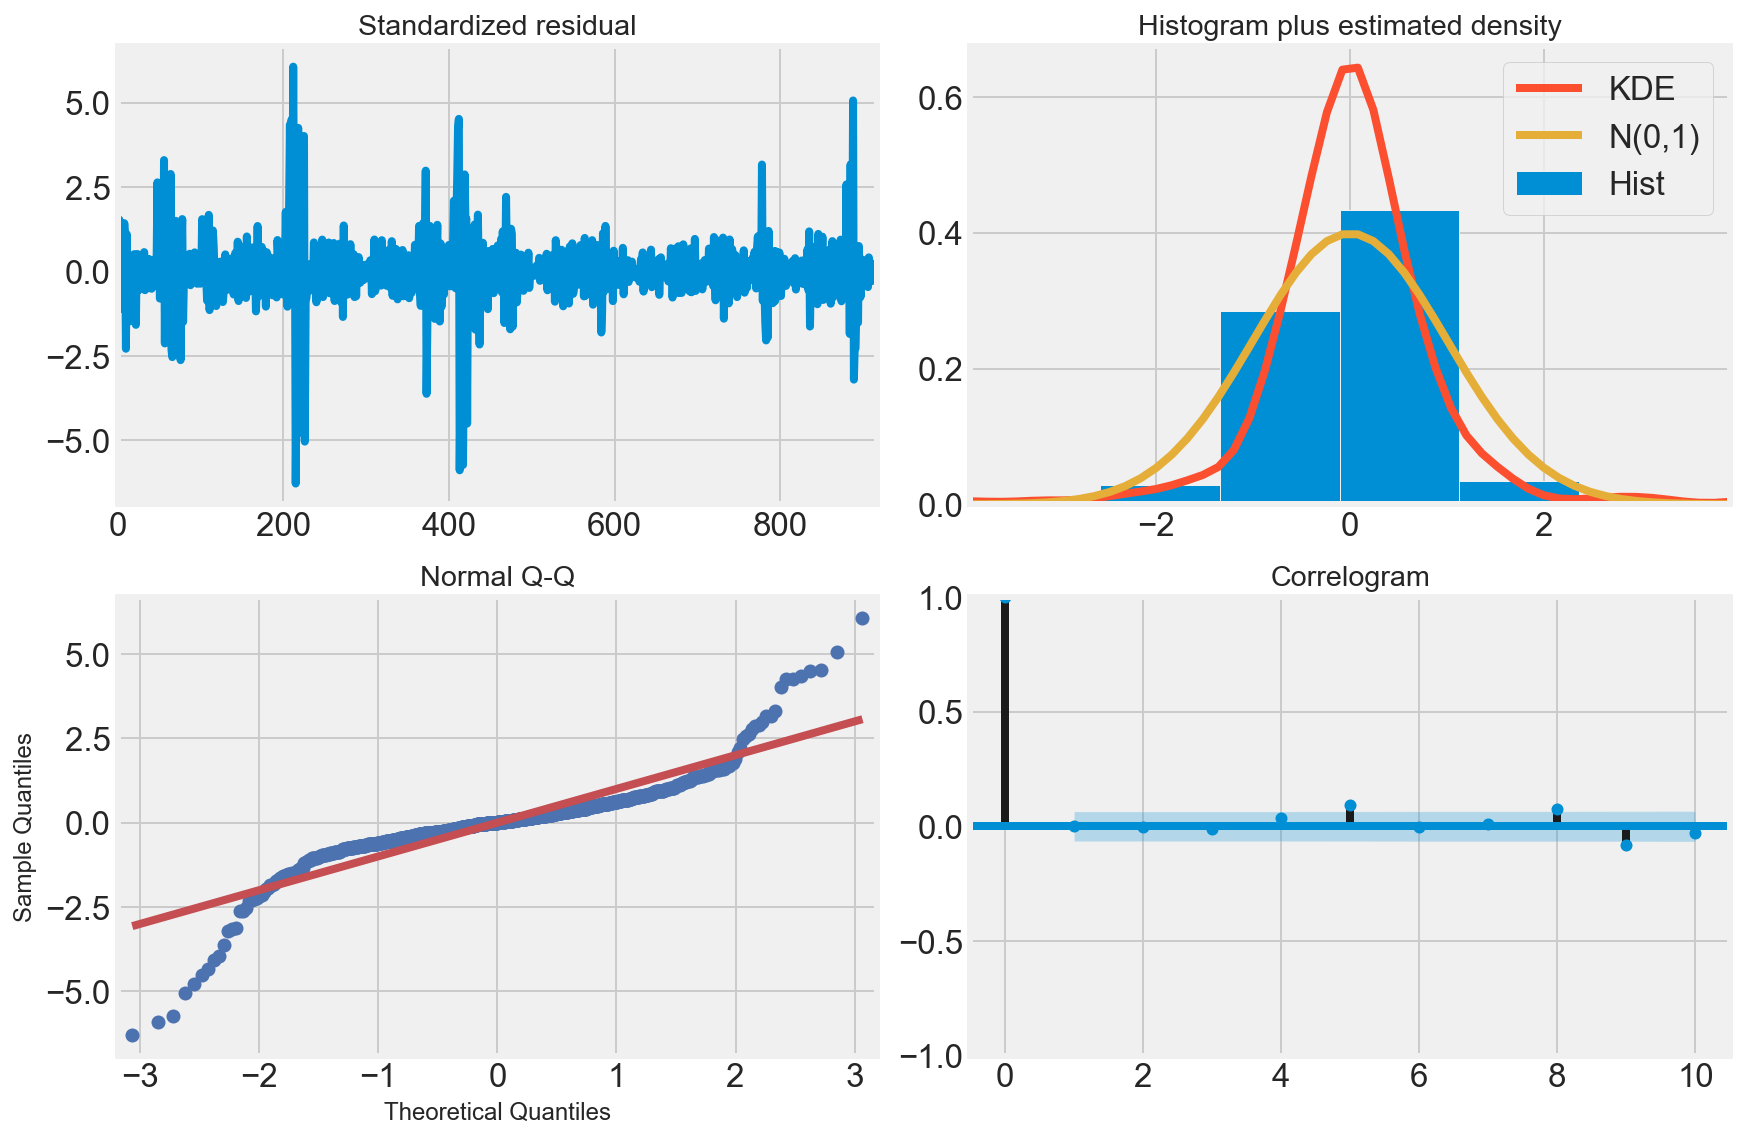

In [122]:
results.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

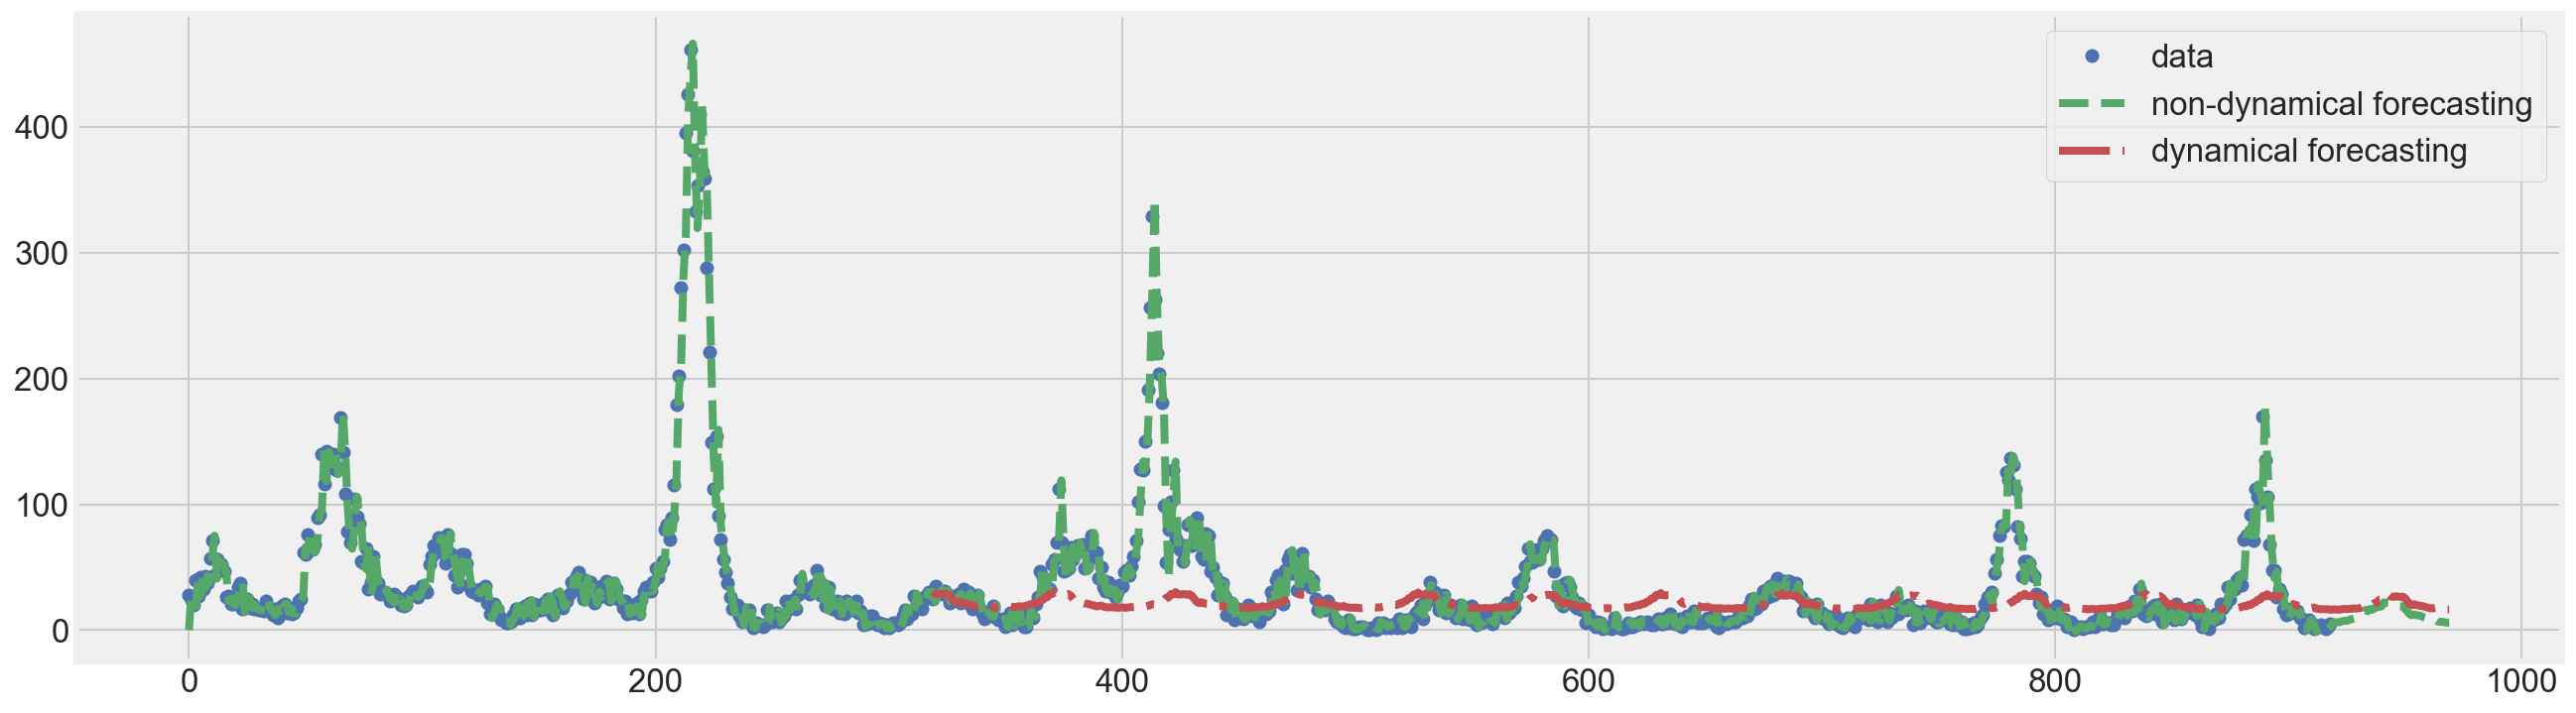

In [123]:
# forecasting
start_p = 600

# two equivalent ways for getting non-dynamical forecasts
# preds = results.forecast(50)
preds = results.predict(start=0,end=len(san_juan)+50,dynamic=False)

preds_dyn = results.predict(start=len(san_juan)-start_p,end=len(san_juan)+50,dynamic=True)
fcast = pd.concat([san_juan.total_cases,preds])
fcast_1 = pd.concat([san_juan.total_cases[:len(san_juan)-start_p],preds_dyn])

preds.shape, preds_dyn.shape, san_juan.total_cases.shape

plt.figure(figsize=(20,6))
plt.plot(san_juan.total_cases.values, 'bo' , preds, 'g--',preds_dyn,'r-.')
plt.legend(['data','non-dynamical forecasting','dynamical forecasting'])
plt.show()

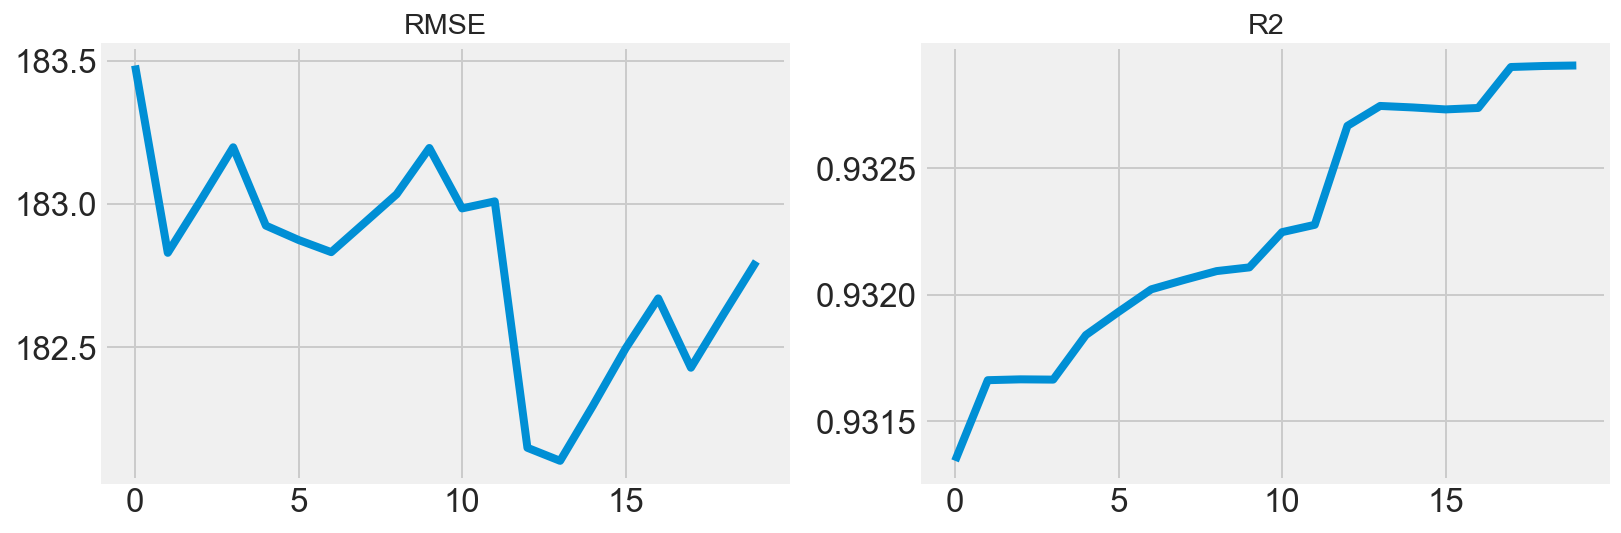

In [124]:
fig, ax = plt.subplots(ncols=2,figsize=(12,4))
ax[0].plot([mean_squared_error(san_juan.total_cases[i:],preds[i:len(san_juan)]) for i in range(20)])
ax[0].set_title('RMSE')
ax[1].plot([r2_score(san_juan.total_cases[i:],preds[i:len(san_juan)]) for i in range(20)])
ax[1].set_title('R2')
plt.show()

In [125]:
#Model to submit in competition with MAE for the competition. Need to merge both cities back together.

In [126]:
dengue_merged.fillna(method='ffill', inplace=True)
dengue_test.fillna(method='ffill', inplace=True)

In [127]:
dengue_train_sj = dengue_merged[dengue_merged['city']=='sj'].reset_index(drop=True)
dengue_test_sj = dengue_test[dengue_test['city']=='sj'].reset_index(drop=True)
dengue_train_iq = dengue_merged[dengue_merged['city']=='iq'].reset_index(drop=True)
dengue_test_iq = dengue_test[dengue_test['city']=='iq'].reset_index(drop=True)
dengue_train_sj['total_cases_shift1'] = dengue_train_sj['total_cases'].shift(1)
dengue_train_sj.fillna(method='bfill', inplace=True)
dengue_test_sj['total_cases_shift1'] = 0
dengue_train_iq['total_cases_shift1'] = dengue_train_iq['total_cases'].shift(1)
dengue_train_iq.fillna(method='bfill', inplace=True)
dengue_test_iq['total_cases_shift1'] = 0

In [128]:
#Model: TARGET: 'total_cases'. Dataset: sj.
X_sj = dengue_train_sj[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases_shift1']]
y_sj = dengue_train_sj.total_cases

In [129]:
# standardize the data and fit
scaler_sj = StandardScaler()
X_sj = pd.DataFrame(scaler_sj.fit_transform(X_sj), columns=X_sj.columns)

In [130]:
model_sj = Ridge(alpha=1.149756995397737)

# get cross validated scores
# fit and evaluate the data on the whole training set
model_sj.fit(X_sj, y_sj)
print("Score:", model_sj.score(X_sj, y_sj))

Score: 0.9331521462068643


In [131]:
train_pred_sj = model_sj.predict(X_sj)

In [132]:
train_pred_sj = [int(x) for x in train_pred_sj]

In [133]:
mean_absolute_error(y_sj, train_pred_sj)

7.895299145299146

In [134]:
#Model: TARGET: 'total_cases'. Dataset: iq.
X_iq = dengue_train_iq[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases_shift1']]
y_iq = dengue_train_iq.total_cases

In [135]:
# standardize the data and fit
scaler_iq = StandardScaler()
X_iq = pd.DataFrame(scaler_iq.fit_transform(X_iq), columns=X_iq.columns)

In [136]:
model_iq = Ridge(alpha=14.174741629268063)

# get cross validated scores
# fit and evaluate the data on the whole training set
model_iq.fit(X_iq, y_iq)
print("Score:", model_iq.score(X_iq, y_iq))

Score: 0.5717031375351415


In [137]:
train_pred_iq = model_iq.predict(X_iq)

In [138]:
train_pred_iq = [int(x) for x in train_pred_iq]

In [139]:
mean_absolute_error(y_iq, train_pred_iq)

3.85

In [140]:
model_iq

Ridge(alpha=14.174741629268063, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [141]:
model_sj

Ridge(alpha=1.149756995397737, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [142]:
dengue_test_sj.total_cases_shift1[0] = list(dengue_train_sj.total_cases)[-1]

In [143]:
dengue_test_iq.total_cases_shift1[0] = list(dengue_train_iq.total_cases)[-1]

In [144]:
cols = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases_shift1']

In [157]:
for index in range(len(dengue_test_sj)):
    if model_sj.predict(scaler_sj.transform(dengue_test_sj.loc[index, cols].values.reshape(1,-1)))[0]<461:
        dengue_test_sj.total_cases_shift1[index+1] = 461
    else:
        dengue_test_sj.total_cases_shift1[index+1] = \
                   int(model_sj.predict(scaler_sj.transform(dengue_test_sj.loc[index, cols].values.reshape(1,-1)))[0])

In [166]:
for index in range(len(dengue_test_iq)):
    if model_iq.predict(scaler_iq.transform(dengue_test_iq.loc[index, cols].values.reshape(1,-1)))[0]<116:
        dengue_test_iq.total_cases_shift1[index+1] = \
                   int(model_iq.predict(scaler_iq.transform(dengue_test_iq.loc[index, cols].values.reshape(1,-1)))[0])
    else:
        dengue_test_iq.total_cases_shift1[index+1] = 116

In [167]:
submission_cols = ['city', 'year', 'weekofyear', 'total_cases']

In [168]:
sj_predictions = [int(x) for x in model_sj.predict(scaler_sj.transform(dengue_test_sj[cols]))]

In [169]:
mean_iq = int(dengue_train_iq.total_cases.mean())

In [170]:
iq_predictions = [int(x) if x<116 else mean_iq for x in model_iq.predict(scaler_iq.transform(dengue_test_iq[cols]))]

In [171]:
dengue_test_iq['total_cases'] = iq_predictions
dengue_test_sj['total_cases'] = sj_predictions

In [172]:
submission = pd.concat([dengue_test_sj, dengue_test_iq]).reset_index(drop=True)
submission = submission[submission_cols]

In [173]:
submission.tail()

,city,year,weekofyear,total_cases
411,iq,2013,22,7
412,iq,2013,23,7
413,iq,2013,24,6
414,iq,2013,25,6
415,iq,2013,26,4


In [ ]:
submission.to_csv('natasha_dengue.csv', index=False)